In [1]:
import pandas as pd
df=pd.read_csv("preprocessed_dataset.csv")

In [2]:
import numpy as np
import statsmodels.formula.api as smf

# treatment already coded: 1 = (Buy One Get One OR Discount), 0 = No Offer
y = df['conversion']  # outcome
t = df['treatment']   # exposure


In [3]:
#Function to compute four-cell risks
def four_cell_risks(df, y, t, b):
    # ensure column exists
    if b not in df.columns:
        raise KeyError(f"{b} not found in dataframe")

    # group by treatment and modifier
    g = df.groupby([t, b])[y].agg(['mean','size']).rename(
        columns={'mean':'risk','size':'n'}
    ).reset_index()

    # dictionary of observed risks and counts
    cells = {(row[t], row[b]): (row['risk'], row['n']) for _, row in g.iterrows()}

    # helper to safely extract risks and counts
    def get_val(i, j, idx):
        return cells.get((i, j), (np.nan, 0))[idx]

    return {
        'R00': get_val(0,0,0), 'R10': get_val(1,0,0),
        'R01': get_val(0,1,0), 'R11': get_val(1,1,0),
        'N00': get_val(0,0,1), 'N10': get_val(1,0,1),
        'N01': get_val(0,1,1), 'N11': get_val(1,1,1)
    }



In [4]:
#Additive Interaction (AERI)
def aeri_from_risks(R):
    return R['R11'] + R['R00'] - R['R10'] - R['R01']


In [5]:
#Logistic regression with interaction term (Multiplicative)
def fit_interaction_logit(df, y, t, b, adjust=None):
    adjust = adjust or []
    rhs = [t, b, f"{t}:{b}"] + adjust
    formula = f"{y} ~ " + " + ".join(rhs)
    return smf.logit(formula, data=df).fit(disp=0)


In [7]:
#RERI and Modified AP (Additive on ratio scale)
def reri_from_logit(model, t, b):
    params = model.params
    OR_T    = np.exp(params.get(t, 0.0))
    OR_B    = np.exp(params.get(b, 0.0))
    OR_TxB  = np.exp(params.get(f"{t}:{b}", 0.0))
    OR_11   = OR_T * OR_B * OR_TxB
    RERI    = OR_11 - OR_T - OR_B + 1
    modified_AP = np.nan if OR_11==1 else RERI / (OR_11 - 1)
    return dict(OR_T=OR_T, OR_B=OR_B, OR_TxB=OR_TxB, OR_11=OR_11,
                RERI=RERI, modified_AP=modified_AP)


In [8]:
def bootstrap_metric(df, y, t, b, metric='AERI', n_boot=1000, alpha=0.05):
    """Compute bootstrap mean and 95% CI for AERI, RERI, or modified AP."""
    boot_stats = []
    n = len(df)

    for _ in range(n_boot):
        sample = df.sample(n, replace=True)
        try:
            if metric == 'AERI':
                R = four_cell_risks(sample, y, t, b)
                boot_stats.append(aeri_from_risks(R))
            else:  # RERI or modified_AP
                model = fit_interaction_logit(sample, y, t, b)
                reri_res = reri_from_logit(model, t, b)
                if metric == 'RERI':
                    boot_stats.append(reri_res['RERI'])
                elif metric == 'modified_AP':
                    boot_stats.append(reri_res['modified_AP'])
        except Exception as e:
            # optional: print(f"Bootstrap iteration failed: {e}")
            continue

    if len(boot_stats) == 0:
        raise ValueError("All bootstrap iterations failed.")

    mean = np.mean(boot_stats)
    lower = np.percentile(boot_stats, 100*alpha/2)
    upper = np.percentile(boot_stats, 100*(1-alpha/2))

    return mean, lower, upper


In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -------------------------------
# STEP 1: Variables
# -------------------------------
y = 'conversion'   # outcome
t = 'treatment'    # exposure

# Candidate binary effect modifiers
candidate_modifiers = [
    'used_discount','used_bogo','is_referral',
    'channel_Phone','channel_Web',
    'zip_code_Urban','zip_code_Surburban',
    'history_group_Low_spenders', 'history_group_Lowermid_spenders', 'history_group_Uppermid_spenders',
    'recency_group_Low_engagement', 'recency_group_Moderate_engagement'
]

# Keep only those actually in dataframe
binary_modifiers = [col for col in candidate_modifiers if col in df.columns]

print("Binary modifiers being tested:", binary_modifiers)

# -------------------------------
# STEP 3: Loop over modifiers with bootstrap CIs
# -------------------------------
results = []

for b in binary_modifiers:
    try:
        # 1. Four-cell risks and AERI
        R = four_cell_risks(df, y, t, b)
        AERI = aeri_from_risks(R)
        AERI_mean, AERI_lower, AERI_upper = bootstrap_metric(df, y, t, b, metric='AERI')

        # 2. Logistic regression with interaction
        m = fit_interaction_logit(df, y, t, b)
        add = reri_from_logit(m, t, b)

         # --- Multiplicative interaction OR and 95% Wald CI ---
        interaction_term = f"{t}:{b}"
        if interaction_term in m.params.index:
            beta = m.params[interaction_term]
            se = m.bse[interaction_term]
            OR_TxB = np.exp(beta)
            OR_lower = np.exp(beta - 1.96 * se)
            OR_upper = np.exp(beta + 1.96 * se)
        else:
            OR_TxB, OR_lower, OR_upper = np.nan, np.nan, np.nan

        # 3. Bootstrap RERI and modified AP
        RERI_mean, RERI_lower, RERI_upper = bootstrap_metric(df, y, t, b, metric='RERI')
        AP_mean, AP_lower, AP_upper = bootstrap_metric(df, y, t, b, metric='modified_AP')

        results.append({
            'modifier': b,
            'N00': R['N00'],'N10': R['N10'],'N01': R['N01'],'N11': R['N11'],
            'R00': R['R00'],'R10': R['R10'],'R01': R['R01'],'R11': R['R11'],
            'AERI': AERI,
            'AERI_CI_lower': AERI_lower, 'AERI_CI_upper': AERI_upper,
            'OR_TxB': add['OR_TxB'], 'OR_CI_lower': OR_lower, 'OR_CI_upper': OR_upper,
            'RERI': add['RERI'],
            'RERI_CI_lower': RERI_lower, 'RERI_CI_upper': RERI_upper,
            'modified_AP': add['modified_AP'],
            'AP_CI_lower': AP_lower, 'AP_CI_upper': AP_upper,
            'p_interaction': m.pvalues.get(f"{t}:{b}", np.nan)
        })
    except Exception as e:
        print(f"Skipping {b} due to error: {e}")

# -------------------------------
# STEP 4: Show results
# -------------------------------
summary = pd.DataFrame(results).round(3)
print(summary)

Binary modifiers being tested: ['used_discount', 'used_bogo', 'is_referral', 'channel_Phone', 'channel_Web', 'zip_code_Urban', 'zip_code_Surburban', 'history_group_Low_spenders', 'history_group_Lowermid_spenders', 'history_group_Uppermid_spenders', 'recency_group_Low_engagement', 'recency_group_Moderate_engagement']
                             modifier      N00      N10      N01      N11  \
0                       used_discount   8437.0  17028.0  10635.0  21297.0   
1                           used_bogo   8486.0  16998.0  10586.0  21327.0   
2                         is_referral   9513.0  19057.0   9559.0  19268.0   
3                       channel_Phone  10862.0  21785.0   8210.0  16540.0   
4                         channel_Web  10814.0  21696.0   8258.0  16629.0   
5                      zip_code_Urban  11470.0  22951.0   7602.0  15374.0   
6                  zip_code_Surburban  10503.0  21262.0   8569.0  17063.0   
7          history_group_Low_spenders  14358.0  28689.0   4714.0  

In [10]:
# List of continuous-variable modifiers we created
continuous_modifiers = [
    'recency_group_Low_engagement', 'recency_group_Moderate_engagement',
    'history_group_Low_spenders', 'history_group_Lowermid_spenders',
    'history_group_Uppermid_spenders'
]

# Filter results for continuous variables only
continuous_results = [r for r in results if r['modifier'] in continuous_modifiers]

# Select only relevant columns
columns_of_interest = [
    'modifier', 'R00','R10','R01','R11',
    'OR_TxB', 'AERI','RERI','modified_AP'
]

# Create DataFrame
continuous_summary = pd.DataFrame(continuous_results)[columns_of_interest]

# Round for display
continuous_summary = continuous_summary.round(3)

print(continuous_summary)



                            modifier    R00    R10    R01    R11  OR_TxB  \
0         history_group_Low_spenders  0.117  0.179  0.107  0.169   1.033   
1    history_group_Lowermid_spenders  0.123  0.187  0.091  0.147   1.060   
2    history_group_Uppermid_spenders  0.112  0.175  0.125  0.181   0.917   
3       recency_group_Low_engagement  0.132  0.196  0.090  0.150   1.126   
4  recency_group_Moderate_engagement  0.112  0.175  0.120  0.179   0.955   

    AERI   RERI  modified_AP  
0  0.000 -0.014       -0.027  
1 -0.007 -0.115       -0.504  
2 -0.007 -0.067       -0.088  
3 -0.003 -0.080       -0.512  
4 -0.003 -0.029       -0.040  


In [11]:

continuous_summary.to_csv("continuous_summary.csv", index=False)
print("Summary table saved as continuous_summary.csv")

Summary table saved as continuous_summary.csv


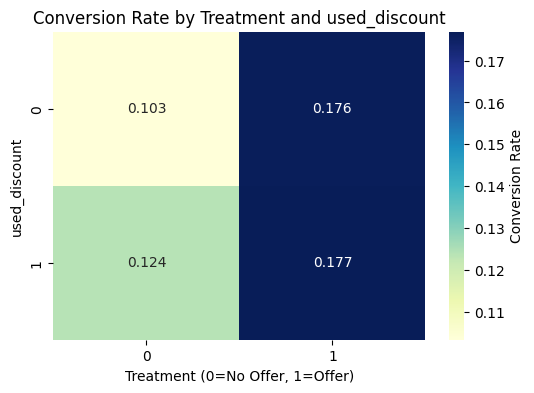

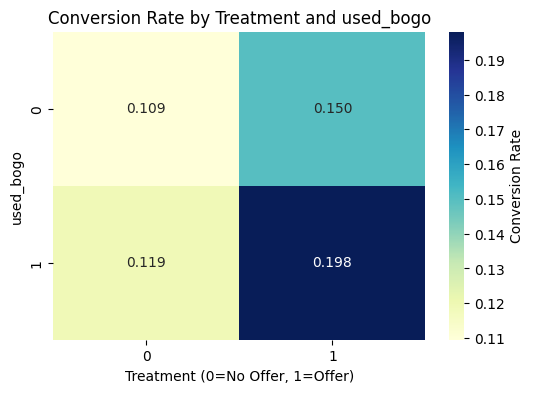

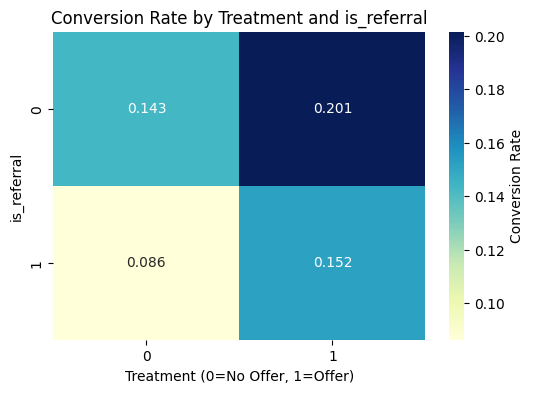

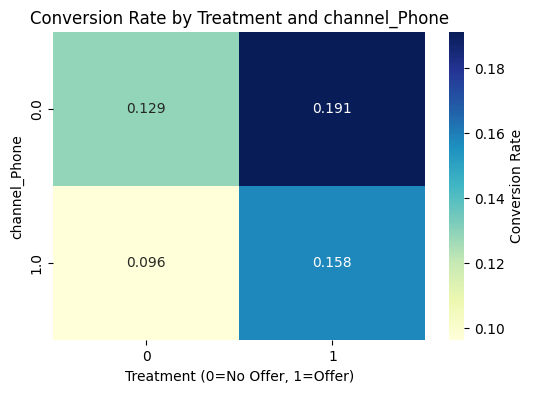

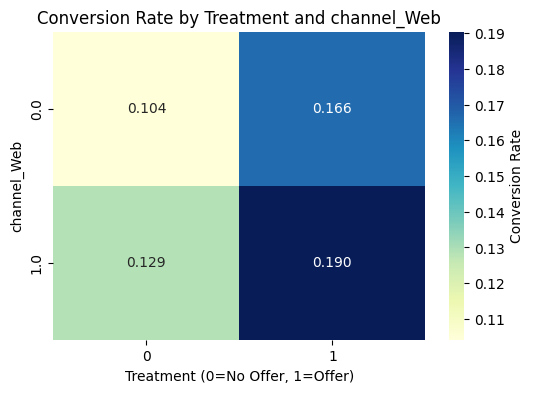

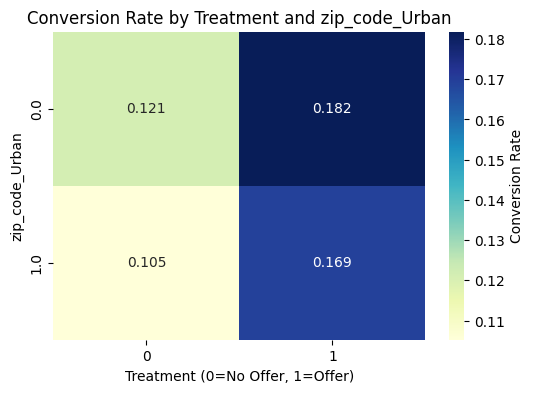

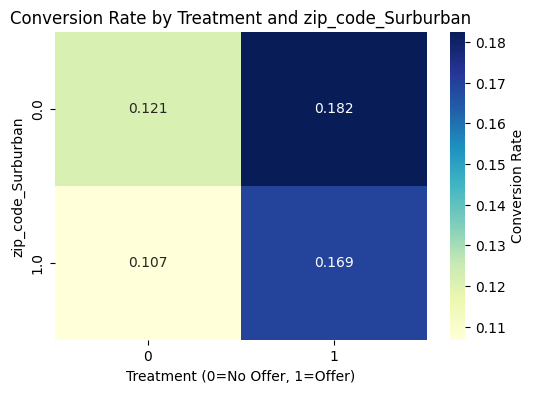

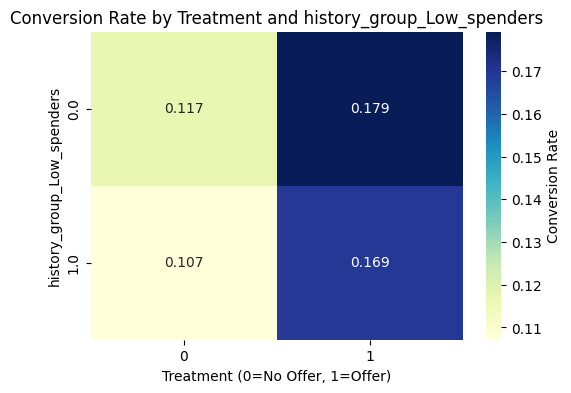

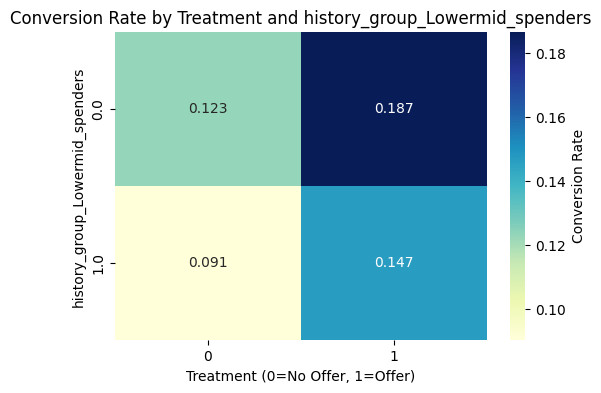

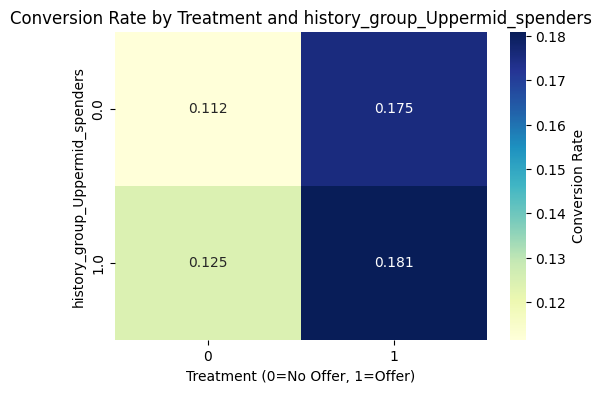

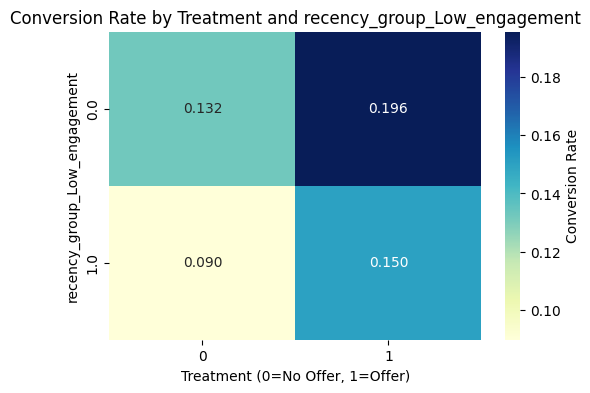

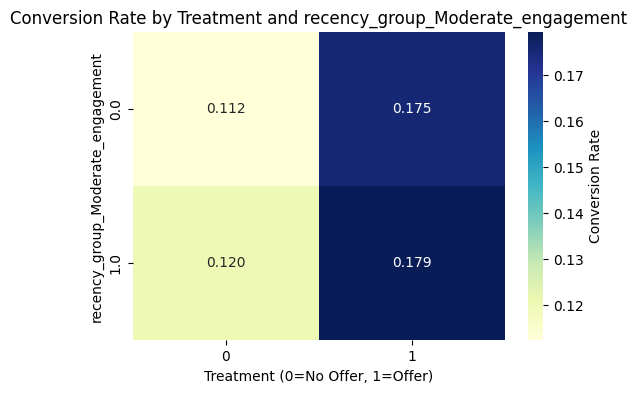

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the modifiers to visualize
modifiers = [
    'used_discount', 'used_bogo', 'is_referral',
    'channel_Phone','channel_Web',
    'zip_code_Urban','zip_code_Surburban',
    'history_group_Low_spenders','history_group_Lowermid_spenders','history_group_Uppermid_spenders',
    'recency_group_Low_engagement','recency_group_Moderate_engagement'
]

# Loop through each modifier and create a heatmap
for mod in modifiers:
    # Compute conversion rates by treatment x modifier
    pivot = df.groupby(['treatment', mod])['conversion'].mean().reset_index()
    pivot_table = pivot.pivot(index=mod, columns='treatment', values='conversion')

    # Plot heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Conversion Rate'})
    plt.title(f'Conversion Rate by Treatment and {mod}')
    plt.xlabel('Treatment (0=No Offer, 1=Offer)')
    plt.ylabel(mod)
    plt.show()


In [13]:
R = four_cell_risks(df, y, t, 'used_discount')
print(R)


{'R00': np.float64(0.10335427284579828), 'R10': np.float64(0.17647404275311251), 'R01': np.float64(0.12383638928067701), 'R11': np.float64(0.17687937268159834), 'N00': np.float64(8437.0), 'N10': np.float64(17028.0), 'N01': np.float64(10635.0), 'N11': np.float64(21297.0)}


In [14]:
import pandas as pd
import numpy as np

# Copy summary to avoid modifying original
report = summary.copy()

# -----------------------------
# 1. Compute total N and events per subgroup
# -----------------------------
report['Control_N'] = report['N00'] + report['N01']
report['Control_Events'] = report['R00']*report['N00'] + report['R01']*report['N01']

report['Treatment_N'] = report['N10'] + report['N11']
report['Treatment_Events'] = report['R10']*report['N10'] + report['R11']*report['N11']

# Conversion rates
report['Control_Rate'] = report['Control_Events'] / report['Control_N']
report['Treatment_Rate'] = report['Treatment_Events'] / report['Treatment_N']

# -----------------------------
# 2. Compute subgroup OR (treatment vs control)
# -----------------------------
# Add small constant to avoid division by zero
eps = 1e-6
report['OR'] = (report['Treatment_Rate'] / (1 - report['Treatment_Rate'] + eps)) / \
               (report['Control_Rate'] / (1 - report['Control_Rate'] + eps))

# -----------------------------
# 3. Interaction direction
# -----------------------------
def interaction_direction(row):
    add = row['RERI']
    mult = row['OR_TxB']
    direction = []

    # Additive
    if add > 0: direction.append("Additive Positive")
    elif add < 0: direction.append("Additive Negative")
    else: direction.append("Additive None")

    # Multiplicative
    if mult > 1: direction.append("Multiplicative Positive")
    elif mult < 1: direction.append("Multiplicative Negative")
    else: direction.append("Multiplicative None")

    return ", ".join(direction)

report['Interaction_Direction'] = report.apply(interaction_direction, axis=1)

# -----------------------------
# 4. Select and reorder columns for reporting
# -----------------------------
columns_order = [
    'modifier',
    'AERI', 'AERI_CI_lower', 'AERI_CI_upper',
    'RERI', 'RERI_CI_lower', 'RERI_CI_upper',
    'modified_AP', 'AP_CI_lower', 'AP_CI_upper',
    'OR_TxB', 'OR_CI_lower', 'OR_CI_upper','p_interaction', 'Interaction_Direction'
]

report = report[columns_order]

# Round numeric columns for readability
numeric_cols = report.select_dtypes(include='number').columns
report[numeric_cols] = report[numeric_cols].round(3)

# -----------------------------
# 5. Save the report
# -----------------------------
report.to_csv("interaction_full_report.csv", index=False)
print("✅ Full interaction report saved as 'interaction_full_report.csv'")

# Display first few rows
report.head(20)


✅ Full interaction report saved as 'interaction_full_report.csv'


modifier   AERI  AERI_CI_lower  AERI_CI_upper  \
0                       used_discount -0.020         -0.032         -0.008   
1                           used_bogo  0.039          0.027          0.051   
2                         is_referral  0.008         -0.004          0.020   
3                       channel_Phone -0.001         -0.013          0.010   
4                         channel_Web -0.000         -0.013          0.012   
5                      zip_code_Urban  0.003         -0.010          0.015   
6                  zip_code_Surburban  0.002         -0.010          0.014   
7          history_group_Low_spenders  0.000         -0.013          0.015   
8     history_group_Lowermid_spenders -0.007         -0.020          0.007   
9     history_group_Uppermid_spenders -0.007         -0.022          0.007   
10       recency_group_Low_engagement -0.003         -0.014          0.008   
11  recency_group_Moderate_engagement -0.003         -0.016          0.009   

     RERI  RERI_CI_lower  RERI_CI_upper  modified_AP  AP_CI_lower  \
0  -0.221         -0.376         -0.079       -0.256       -0.418   
1   0.477          0.363          0.589        0.472        0.341   
2   0.001         -0.099          0.099        0.017       -1.876   
3  -0.055         -0.175          0.046       -0.207       -0.662   
4   0.038         -0.109          0.170        0.038       -0.101   
5   0.010         -0.116          0.130        0.021       -0.236   
6  -0.005         -0.120          0.106       -0.010       -0.282   
7  -0.014         -0.144          0.120       -0.027       -0.309   
8  -0.115         -0.238         -0.001       -0.504       -1.298   
9  -0.067         -0.221          0.083       -0.088       -0.319   
10 -0.080         -0.188          0.023       -0.512       -1.338   
11 -0.029         -0.172          0.105       -0.040       -0.261   

    AP_CI_upper  OR_TxB  OR_CI_lower  OR_CI_upper  p_interaction  \
0        -0.097   0.818        0.736        0.908          0.000   
1         0.607   1.275        1.148        1.416          0.000   
2         4.003   1.261        1.135        1.402          0.000   
3         0.196   1.097        0.986        1.220          0.090   
4         0.177   0.929        0.837        1.030          0.162   
5         0.275   1.072        0.964        1.193          0.199   
6         0.222   1.056        0.951        1.172          0.310   
7         0.214   1.033        0.914        1.166          0.607   
8         0.031   1.060        0.933        1.204          0.373   
9         0.120   0.917        0.816        1.031          0.149   
10        0.136   1.126        1.010        1.256          0.033   
11        0.157   0.955        0.856        1.067          0.417   

                         Interaction_Direction  
0   Additive Negative, Multiplicative Negative  
1   Additive Positive, Multiplicative Positive  
2   Additive Positive, Multiplicative Positive  
3   Additive Negative, Multiplicative Positive  
4   Additive Positive, Multiplicative Negative  
5   Additive Positive, Multiplicative Positive  
6   Additive Negative, Multiplicative Positive  
7   Additive Negative, Multiplicative Positive  
8   Additive Negative, Multiplicative Positive  
9   Additive Negative, Multiplicative Negative  
10  Additive Negative, Multiplicative Positive  
11  Additive Negative, Multiplicative Negative

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def interaction_plots_all_in_one(df, treatment, outcome, modifiers, save_path=None):
    """
    Generate multiple interaction plots in a single figure.

    Parameters:
    - df: DataFrame
    - treatment: treatment variable (str)
    - outcome: outcome variable (str)
    - modifiers: list of effect modifiers (list of str)
    - save_path: optional file path to save the figure
    """
    n = len(modifiers)
    ncols = 2  # adjust number of columns
    nrows = (n + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()  # flatten to 1D array for easy iteration

    for i, mod in enumerate(modifiers):
        plot_data = df.groupby([treatment, mod])[outcome].mean().reset_index()

        sns.pointplot(
            data=plot_data,
            x=treatment, y=outcome,
            hue=mod, dodge=True,
            markers=["o","s"], linestyles=["-","--"],
            ax=axes[i]
        )
        axes[i].set_title(f"{treatment} × {mod}")
        axes[i].set_ylabel("Mean Conversion Rate")
        axes[i].set_xlabel("Treatment")

    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"All interaction plots saved to {save_path}")

    plt.show()


All interaction plots saved to all_interactions.png


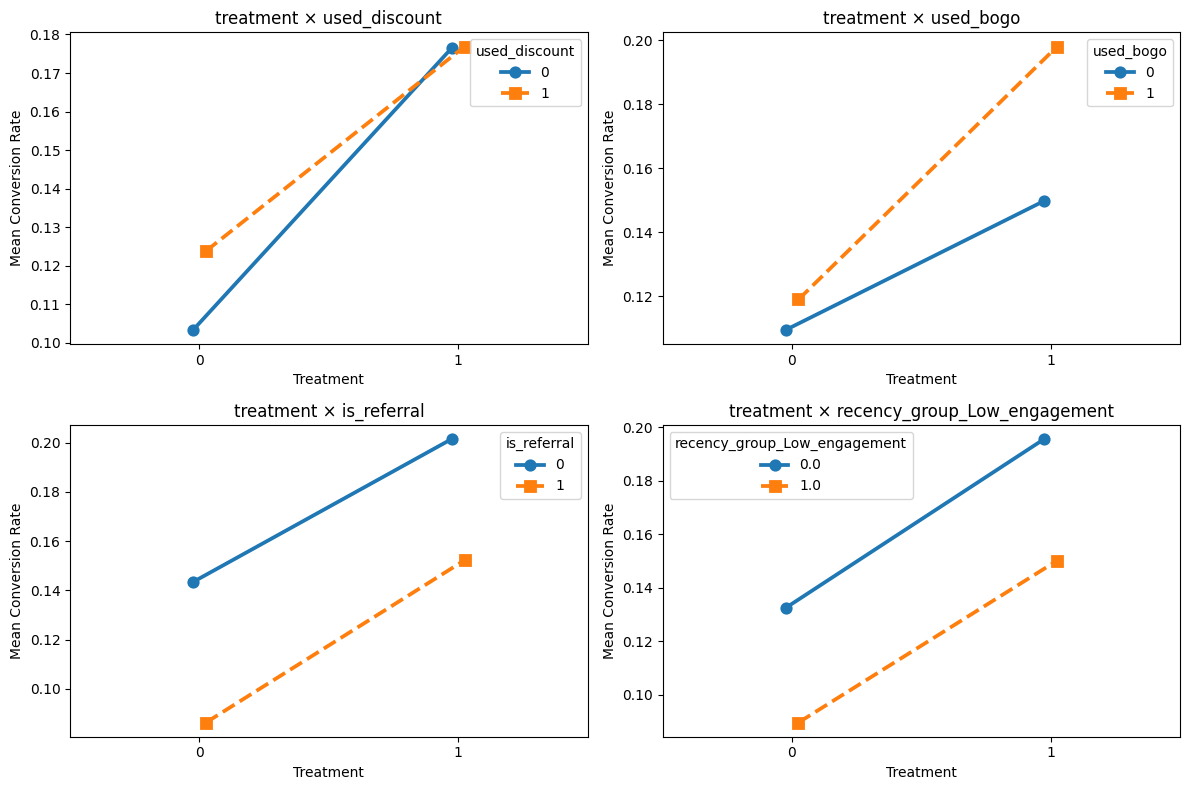

In [33]:
modifiers_list = ["used_discount", "used_bogo", "is_referral", "recency_group_Low_engagement"]
interaction_plots_all_in_one(df, treatment="treatment", outcome="conversion",
                             modifiers=modifiers_list, save_path="all_interactions.png")
